# Integrated Gradients

In [19]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [20]:
print(tf.__version__)

2.8.0


In [21]:
model = tf.keras.Sequential([
    hub.KerasLayer(
        name='inception_v1',
        handle='https://tfhub.dev/google/imagenet/inception_v1/classification/4',
        trainable=False),
])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v1 (KerasLayer)   (None, 1001)              6633209   
                                                                 
Total params: 6,633,209
Trainable params: 0
Non-trainable params: 6,633,209
_________________________________________________________________


In [22]:
def load_imagenet_labels(file_path):
  labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
  with open(labels_file) as reader:
    f = reader.read()
    labels = f.splitlines()
  return np.array(labels)

In [23]:
imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

In [24]:
imagenet_labels[0]

'background'

In [25]:
def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
  return image

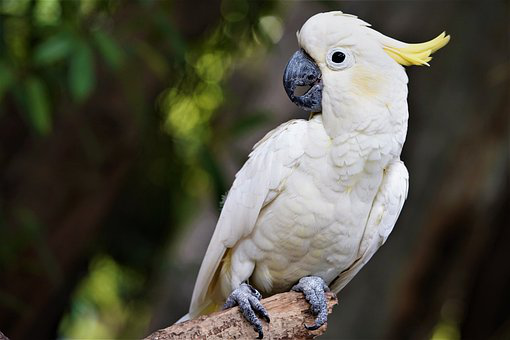

In [26]:
img_path = './images/cockatoo.jpeg'
tf.keras.utils.load_img(img_path, grayscale=False)

In [27]:
image_tensor = read_image(img_path)

In [28]:
# img_url = {
#     # 'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
#     # 'Giant Panda': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg',
#     'Cockatoo': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Cockatoo.jpeg',
# }

# img_paths = {name: tf.keras.utils.get_file(name, url) for (name, url) in img_url.items()}
# img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_paths.items()}

In [29]:
# tf.keras.utils.get_file(

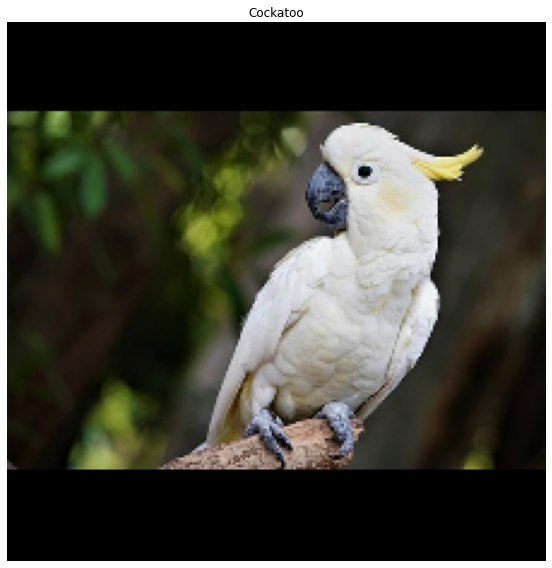

In [30]:
plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1)
ax.imshow(image_tensor)
ax.set_title('Cockatoo')
ax.axis('off')
plt.tight_layout()

In [31]:
def top_k_predictions(img, k=3):
  image_batch = tf.expand_dims(img, 0)
  predictions = model(image_batch)
  probs = tf.nn.softmax(predictions, axis=-1)
  top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
  top_labels = imagenet_labels[tuple(top_idxs)]
  return top_labels, top_probs[0]

In [32]:
pred_label, pred_prob = top_k_predictions(image_tensor)
for label, prob in zip(pred_label, pred_prob):
    print(f'{label}: {prob:0.1%}')

sulphur-crested cockatoo: 99.6%
spoonbill: 0.1%
American egret: 0.0%


## Baselines

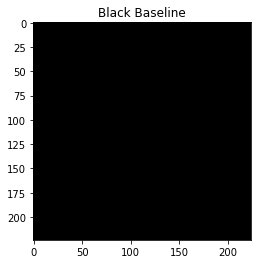

In [51]:
black_baseline = tf.zeros(shape=(224,224,3))
plt.imshow(black_baseline)
plt.title("Black Baseline")
plt.axis('on')
plt.show()

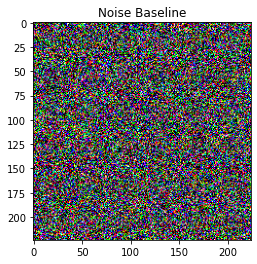

In [34]:
noise_baseline = tf.random.normal(shape=(224,224,3))
plt.imshow(noise_baseline)
plt.title("Noise Baseline")
plt.axis('on')
plt.show()

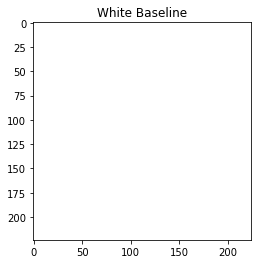

In [35]:
white_baseline = tf.ones(shape=(224,224,3))
plt.imshow(white_baseline)
plt.title("White Baseline")
plt.axis('on')
plt.show()

In [65]:
def interpolate_images(baseline,
                       image,
                       alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    images = alphas_x * input_x + (1 - alphas_x) * baseline_x
    return images

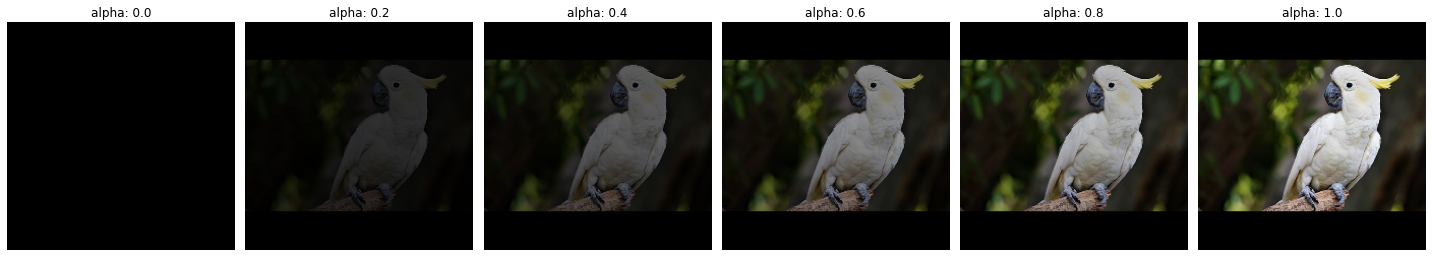

In [66]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
interpolated_images = interpolate_images(black_baseline,
                                         image_tensor,
                                         alphas)

fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout();

In [67]:
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        logits = model(images)
        probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
    return tape.gradient(probs, images)

In [ ]:
LABEL = 'sulphur-crested cockatoo'
pred = model(interpolated_images)

idx_cockatoo = np.where(imagenet_labels==LABEL)[0][0]
pred_proba = tf.nn.softmax(pred, axis=-1)[:, idx_cockatoo]

In [74]:
pred_proba

<tf.Tensor: shape=(51,), dtype=float32, numpy=
array([0.0011114 , 0.001673  , 0.16032079, 0.66458493, 0.8614599 ,
       0.93345875, 0.96149474, 0.97879076, 0.9874348 , 0.9922839 ,
       0.9947606 , 0.9961196 , 0.99704295, 0.9976661 , 0.99815124,
       0.9983954 , 0.99857426, 0.99868566, 0.99876344, 0.99881965,
       0.99882764, 0.99882096, 0.9987947 , 0.9987412 , 0.9986766 ,
       0.99860966, 0.9985331 , 0.9984295 , 0.9983417 , 0.9982668 ,
       0.9981546 , 0.9980095 , 0.99786514, 0.9976973 , 0.9974952 ,
       0.99731404, 0.997171  , 0.9970643 , 0.997012  , 0.9969606 ,
       0.9968899 , 0.9968336 , 0.9967744 , 0.99670887, 0.99662423,
       0.9965585 , 0.99647754, 0.9964071 , 0.9963601 , 0.9963307 ,
       0.9962752 ], dtype=float32)>

(0.0, 1.05)

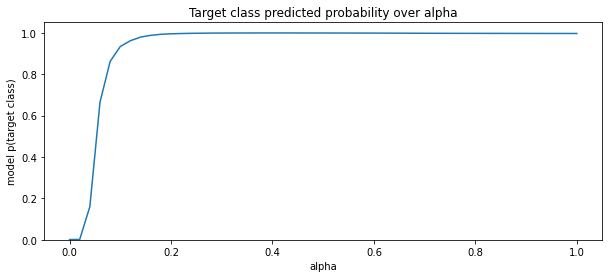

In [75]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 1, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1.05])

In [76]:
path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=idx_cockatoo)

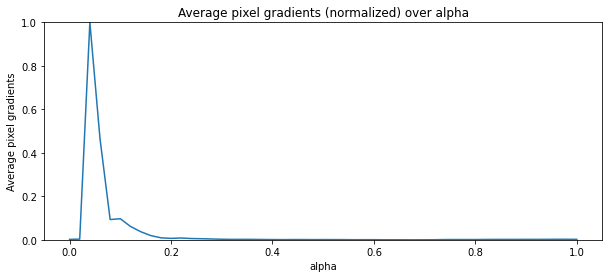

In [77]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 1, 1)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax1.plot(alphas, average_grads_norm)
ax1.set_title('Average pixel gradients (normalized) over alpha')
ax1.set_ylabel('Average pixel gradients')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1]);

### Using a white baseline or noise baseline

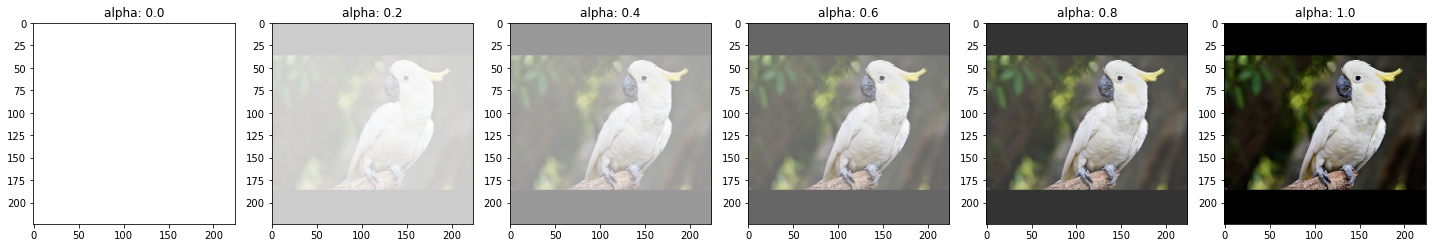

In [60]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
interpolated_images = interpolate_images(white_baseline,
                                         image_tensor,
                                         alphas)

fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('on')

plt.tight_layout();

(0.0, 1.05)

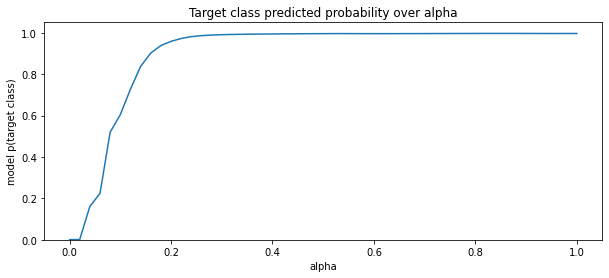

In [61]:
LABEL = 'sulphur-crested cockatoo'
pred = model(interpolated_images)

pred_proba = tf.nn.softmax(pred, axis=-1)[:, idx_cockatoo]

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 1, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1.05])

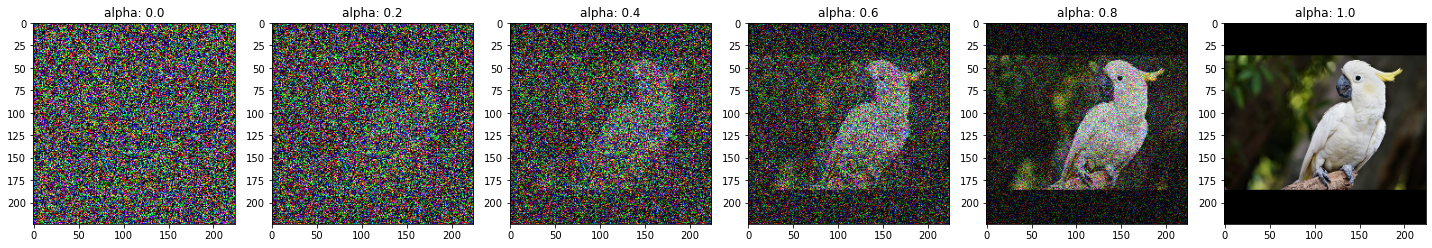

In [62]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
interpolated_images = interpolate_images(noise_baseline,
                                         image_tensor,
                                         alphas)

fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('on')

plt.tight_layout();

(0.0, 1.05)

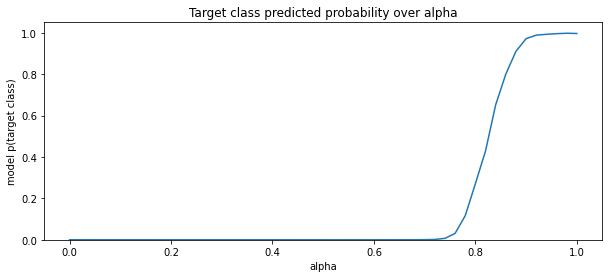

In [63]:
LABEL = 'sulphur-crested cockatoo'
pred = model(interpolated_images)

pred_proba = tf.nn.softmax(pred, axis=-1)[:, idx_cockatoo]

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 1, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1.05])

In [43]:
def integral_approximation(gradients):
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

In [78]:
ig = integral_approximation(
    gradients=path_gradients)

In [79]:
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  # Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Collect gradients.    
  gradient_batches = []

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
    gradient_batches.append(gradient_batch)

  # Concatenate path gradients together row-wise into single tensor.
  total_gradients = tf.concat(gradient_batches, axis=0)

  # Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [80]:
@tf.function
def one_batch(baseline, image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    return gradient_batch

In [82]:
ig_attributions = integrated_gradients(baseline=black_baseline,
                                       image=image_tensor,
                                       target_class_idx=90,
                                       m_steps=240)

In [83]:
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(image, alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.tight_layout()
  return fig

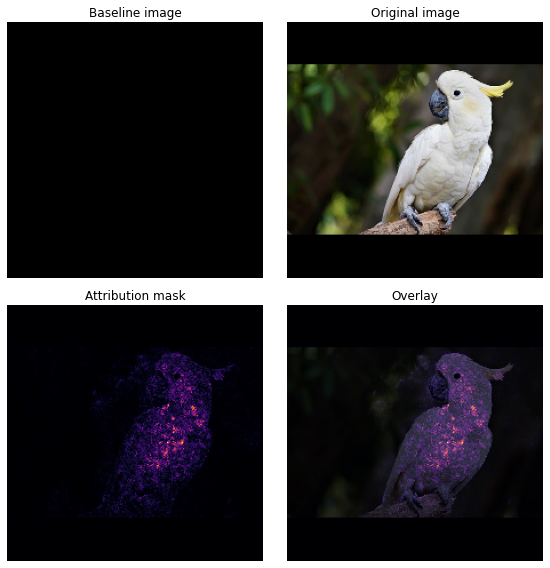

In [84]:
_ = plot_img_attributions(image=image_tensor,
                          baseline=black_baseline,
                          target_class_idx=90,
                          m_steps=5,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.2)

Using Inceptin v3 and with m_steps = 50

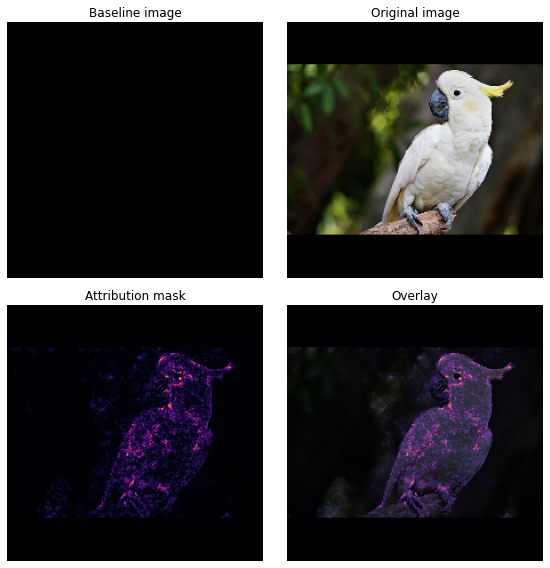

In [179]:
# _ = plot_img_attributions(image=image_tensor,
#                           baseline=black_baseline,
#                           target_class_idx=90,
#                           m_steps=50,
#                           cmap=plt.cm.inferno,
#                           overlay_alpha=0.2)

## Computing Integrated Gradients using the Saliency library

In [85]:
# Boilerplate imports.
import tensorflow as tf
import numpy as np
import PIL.Image
from matplotlib import pylab as P

# From our repository.
import saliency.core as saliency

%matplotlib inline

In [86]:
# Boilerplate methods.
def ShowImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  P.imshow(im)
  P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')

  P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
  P.title(title)

def ShowHeatMap(im, title, ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  P.imshow(im, cmap='inferno')
  P.title(title)

def LoadImage(file_path):
  im = PIL.Image.open(file_path)
  im = im.resize((224,224))
  im = np.asarray(im)
  return im

def PreprocessImage(im):
  im = tf.keras.applications.vgg16.preprocess_input(im)
  return im

Prediction class: 820


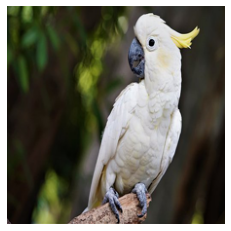

In [94]:
# Load the image
im_orig = LoadImage('./images/cockatoo.jpeg')
im = PreprocessImage(im_orig)

# Show the image
ShowImage(im_orig)

predictions = model(np.array([im]))
prediction_class = np.argmax(predictions[0])
call_model_args = {class_idx_str: prediction_class}

print("Prediction class: " + str(prediction_class))  # Should be a doberman, class idx = 236

In [100]:
class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        tape.watch(images)
        output_layer = model(images)
        output_layer = output_layer[:,target_class_idx]
        gradients = np.array(tape.gradient(output_layer, images))
        return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}

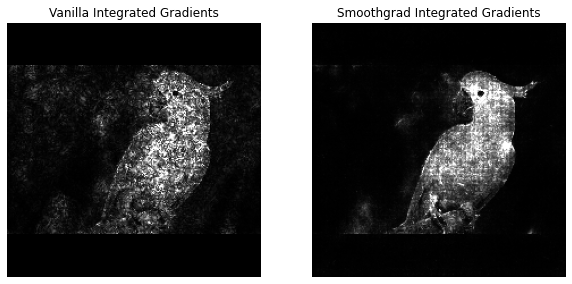

In [101]:
# Construct the saliency object. This alone doesn't do anthing.
integrated_gradients = saliency.IntegratedGradients()

# Baseline is a black image.
baseline = np.zeros(image.shape)

# Compute the vanilla mask and the smoothed mask.
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  image, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)
# Smoothed mask for integrated gradients will take a while since we are doing nsamples * nsamples computations.
smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
  image, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_integrated_gradients_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='Smoothgrad Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))

## Examining convergence of integral approximations

In [103]:
def convergence_check(model, attributions, baseline, input, target_class_idx):
  """
  Args:
    model(keras.Model): A trained model to generate predictions and inspect.
    baseline(Tensor): A 3D image tensor with the shape 
      (image_height, image_width, 3) with the same shape as the input tensor.
    input(Tensor): A 3D image tensor with the shape 
      (image_height, image_width, 3).
    target_class_idx(Tensor): An integer that corresponds to the correct 
      ImageNet class index in the model's output predictions tensor. Default 
        value is 50 steps.   
  Returns:
    (none): Prints scores and convergence delta to sys.stdout.
  """
  # Your model's prediction on the baseline tensor. Ideally, the baseline score
  # should be close to zero.
  baseline_prediction = model(tf.expand_dims(baseline, 0))
  baseline_score = tf.nn.softmax(tf.squeeze(baseline_prediction))[target_class_idx]
  # Your model's prediction and score on the input tensor.
  input_prediction = model(tf.expand_dims(input, 0))
  input_score = tf.nn.softmax(tf.squeeze(input_prediction))[target_class_idx]
  # Sum of your IG prediction attributions.
  ig_score = tf.math.reduce_sum(attributions)
  delta = ig_score - (input_score - baseline_score)
  try:
    # Test your IG score is <= 5% of the input minus baseline score.
    tf.debugging.assert_near(ig_score, (input_score - baseline_score), rtol=0.05)
    tf.print('Approximation accuracy within 5%.', output_stream=sys.stdout)
  except tf.errors.InvalidArgumentError:
    tf.print('Increase or decrease m_steps to increase approximation accuracy.', output_stream=sys.stdout)
  
  tf.print('Baseline score: {:.3f}'.format(baseline_score))
  tf.print('Input score: {:.3f}'.format(input_score))
  tf.print('IG score: {:.3f}'.format(ig_score))     
  tf.print('Convergence delta: {:.3f}'.format(delta))